In [2]:
# ============================================
# IMPORTS & ENVIRONMENT SETUP
# ============================================

%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

import wandb
wandb.login()

print("PyTorch:", torch.__version__)
print("CUDA:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


PyTorch: 2.5.1+cu121
CUDA: True
GPU: NVIDIA RTX A6000


device(type='cuda')

In [3]:
# ============================================
# LOAD NYC TAXI KDD2020 DATASET
# ============================================

data_root = "/home/nuoxu9/traffic_flow_prediction/data/KDD2020/NYCTaxi"

train_path = os.path.join(data_root, "taxi_train.npz")
val_path   = os.path.join(data_root, "taxi_val.npz")
test_path  = os.path.join(data_root, "taxi_test.npz")

train_npz = np.load(train_path)
val_npz   = np.load(val_path)
test_npz  = np.load(test_path)

print("Train keys:", train_npz.files)
print("Val keys:", val_npz.files)
print("Test keys:", test_npz.files)

flow_train  = train_npz["flow"]      # (T, 16, 12, 2)
trans_train = train_npz["trans"]     # (T, 16, 12, 16, 12, 2)  (dynamic graph weights)
ex_train    = train_npz["ex_knlg"]   # (T, 65)  exogenous knowledge

flow_val  = val_npz["flow"]
flow_test = test_npz["flow"]

print("Flow train shape :", flow_train.shape)
print("Trans train shape:", trans_train.shape)
print("Exogenous shape  :", ex_train.shape)


Train keys: ['flow', 'trans', 'ex_knlg']
Val keys: ['flow', 'trans', 'ex_knlg']
Test keys: ['flow', 'trans', 'ex_knlg']
Flow train shape : (1920, 16, 12, 2)
Trans train shape: (1920, 16, 12, 16, 12, 2)
Exogenous shape  : (1920, 65)


In [4]:
# ============================================
# NORMALIZATION + SLIDING WINDOW (12 → 3)
# ============================================

# flow_train shape: (T, 16, 12, 2)

T, H, W, C = flow_train.shape
print("Training time steps:", T)
print("Grid size:", H, "x", W)
print("Channels (inflow/outflow):", C)

# -------------------------------------------------
# 1. Compute mean & std on training only
# -------------------------------------------------
flow_mean = flow_train.mean(axis=(0,1,2))      # shape (2,)
flow_std  = flow_train.std(axis=(0,1,2)) + 1e-6

print("Flow mean:", flow_mean)
print("Flow std :", flow_std)

def normalize(x):
    return (x - flow_mean) / flow_std

def denormalize(x):
    return x * flow_std + flow_mean


# -------------------------------------------------
# 2. Normalize all splits
# -------------------------------------------------
flow_train_norm = normalize(flow_train)
flow_val_norm   = normalize(flow_val)
flow_test_norm  = normalize(flow_test)

print("Normalized train shape:", flow_train_norm.shape)


# -------------------------------------------------
# 3. Create sliding window dataset
# -------------------------------------------------
def create_dataset(flow, input_len=12, output_len=3):
    """
    flow: (T, 16, 12, 2)
    return:
      X: (N, 12, 16, 12, 2)
      Y: (N, 3, 16, 12, 2)
    """
    X, Y = [], []
    T = flow.shape[0]

    for t in range(T - input_len - output_len):
        X.append(flow[t:t+input_len])                            # [12, H, W, 2]
        Y.append(flow[t+input_len:t+input_len+output_len])       # [3, H, W, 2]

    return np.array(X), np.array(Y)


X_train, Y_train = create_dataset(flow_train_norm)
X_val,   Y_val   = create_dataset(flow_val_norm)
X_test,  Y_test  = create_dataset(flow_test_norm)

print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)


Training time steps: 1920
Grid size: 16 x 12
Channels (inflow/outflow): 2
Flow mean: [32.01392415 32.01924099]
Flow std : [89.42449993 97.83843562]
Normalized train shape: (1920, 16, 12, 2)
X_train: (1905, 12, 16, 12, 2)
Y_train: (1905, 3, 16, 12, 2)


In [5]:
# ============================================
# Pytorch Dataset + DataLoaders
# ============================================

import torch
from torch.utils.data import Dataset, DataLoader

# -------------------------------------------------
# Custom Dataset
# -------------------------------------------------
class TrafficDataset(Dataset):
    def __init__(self, X, Y):
        """
        X: (N, 12, H, W, 2)
        Y: (N, 3,  H, W, 2)
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


# -------------------------------------------------
# Create dataloaders
# -------------------------------------------------
batch_size = 32

train_loader = DataLoader(
    TrafficDataset(X_train, Y_train),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True
)

val_loader = DataLoader(
    TrafficDataset(X_val, Y_val),
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    pin_memory=True
)

test_loader = DataLoader(
    TrafficDataset(X_test, Y_test),
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    pin_memory=True
)

print("Train batches:", len(train_loader))
print("Val batches:  ", len(val_loader))
print("Test batches: ", len(test_loader))


# -------------------------------------------------
# Quick batch shape sanity check
# -------------------------------------------------
Xb, Yb = next(iter(train_loader))
print("Batch X:", Xb.shape)
print("Batch Y:", Yb.shape)


Train batches: 59
Val batches:   18
Test batches:  30
Batch X: torch.Size([32, 12, 16, 12, 2])
Batch Y: torch.Size([32, 3, 16, 12, 2])


In [6]:
# ============================================
# GraphWaveNet I/O Conversion Utilities
# ============================================

def to_gwn_input(X):
    """
    Convert (B,12,16,12,2) → (B,2,192,12), layout = (B, C, N, T)
    """
    B, T, H, W, C = X.shape
    
    # Put channels FIRST, keep time SECOND
    X = X.permute(0, 4, 2, 3, 1)   # (B, C, H, W, T)
    
    # Now collapse H*W into nodes
    X = X.reshape(B, C, H*W, T)    # (B, C, N, T)
    
    return X

Xb, Yb = next(iter(train_loader))
Xg = to_gwn_input(Xb)
print("Xg shape:", Xg.shape)



def from_gwn_output(pred, H=16, W=12, C=2, out_steps=3):
    """
    pred: (B, out_steps*C, N)
    return: (B,3,16,12,2)
    """
    B, OC, N = pred.shape
    pred = pred.reshape(B, out_steps, C, N)  # (B,3,2,192)
    pred = pred.reshape(B, out_steps, C, H, W)
    pred = pred.permute(0,1,3,4,2)          # (B,3,16,12,2)
    return pred


Xg shape: torch.Size([32, 2, 192, 12])


In [7]:
# ============================================================
# OFFICIAL GraphWaveNet Implementation (FIXED w/ Padding)
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F


class nconv(nn.Module):
    def __init__(self):
        super(nconv, self).__init__()

    def forward(self, x, A):
        # x: (B, C, N, T)
        # A: (N, N)
        return torch.einsum("bcnt,nm->bcmt", (x, A))


class gcn(nn.Module):
    def __init__(self, c_in, c_out, order, dropout):
        super(gcn, self).__init__()
        self.nconv = nconv()
        self.mlp = nn.Conv2d(c_in * (order+1), c_out, kernel_size=1)
        self.order = order
        self.dropout = dropout

    def forward(self, x, A):
        out = [x]
        for i in range(self.order):
            x = self.nconv(x, A)
            out.append(x)
        h = torch.cat(out, dim=1)
        h = self.mlp(h)
        return h


class GraphWaveNet(nn.Module):
    def __init__(self, num_nodes, in_dim=2, out_dim=2, out_steps=3,
                 residual_channels=32, dilation_channels=32,
                 skip_channels=256, end_channels=512,
                 blocks=4, layers=2, dropout=0.3):
        super(GraphWaveNet, self).__init__()

        self.num_nodes = num_nodes
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.out_steps = out_steps
        self.dropout = dropout
        self.blocks = blocks
        self.layers = layers

        self.start_conv = nn.Conv2d(in_dim, residual_channels, kernel_size=1)

        # Adaptive adjacency
        self.nodevec1 = nn.Parameter(torch.randn(num_nodes, 10))
        self.nodevec2 = nn.Parameter(torch.randn(10, num_nodes))

        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.residual_convs = nn.ModuleList()
        self.skip_convs = nn.ModuleList()

        self.bn = nn.ModuleList()
        self.gconvs = nn.ModuleList()

        # -------------------------------------------------------
        # Calculate Receptive Field to determine needed padding
        # -------------------------------------------------------
        self.receptive_field = 1
        dilations = [2**i for i in range(layers)]
        
        for b in range(blocks):
            for d in dilations:
                # Kernel size is (1, 2), so receptive field increases by d * (2 - 1)
                self.receptive_field += d
                
                self.filter_convs.append(
                    nn.Conv2d(residual_channels,
                              dilation_channels,
                              kernel_size=(1,2),
                              dilation=(1,d))
                )
                self.gate_convs.append(
                    nn.Conv2d(residual_channels,
                              dilation_channels,
                              kernel_size=(1,2),
                              dilation=(1,d))
                )
                self.residual_convs.append(
                    nn.Conv2d(dilation_channels,
                              residual_channels,
                              kernel_size=1)
                )
                self.skip_convs.append(
                    nn.Conv2d(dilation_channels,
                              skip_channels,
                              kernel_size=1)
                )
                self.bn.append(nn.BatchNorm2d(residual_channels))

                self.gconvs.append(gcn(residual_channels,
                                       residual_channels,
                                       order=2, dropout=dropout))

        self.end_conv_1 = nn.Conv2d(skip_channels, end_channels, kernel_size=1)
        self.end_conv_2 = nn.Conv2d(end_channels,
                                    out_steps*out_dim, kernel_size=1)

    def forward(self, x):
        """
        x: (B, C, N, T)
        """
        # -------------------------------------------------------
        # FIX 1: Auto-Padding
        # If input T is shorter than Receptive Field, pad the left side (past).
        # -------------------------------------------------------
        if x.size(3) < self.receptive_field:
            x = F.pad(x, (self.receptive_field - x.size(3), 0, 0, 0))

        A = F.softmax(F.relu(torch.mm(self.nodevec1, self.nodevec2)), dim=1)

        x = self.start_conv(x)
        skip = 0

        for fc, gc, rc, sc, bn, gcn_layer in zip(
            self.filter_convs, self.gate_convs,
            self.residual_convs, self.skip_convs,
            self.bn, self.gconvs
        ):
            residual = x

            # dilated temporal convolution
            f = torch.tanh(fc(residual))
            g = torch.sigmoid(gc(residual))
            x = f * g
            
            # -------------------------------------------------------
            # FIX 2: Crop Residual to match X
            # -------------------------------------------------------
            residual = residual[..., -x.size(3):]

            # graph conv
            x = x + gcn_layer(x, A)

            # skip connection
            s = sc(x)
            
            # Accumulate skip (aligned to the right/current time)
            if isinstance(skip, int):
                skip = s
            else:
                skip = skip[..., -x.size(3):] + s

            # residual connection
            x = rc(x) + residual
            x = bn(x)

        x = F.relu(skip)
        x = F.relu(self.end_conv_1(x))
        x = self.end_conv_2(x)  # (B, out_steps*out_dim, N, T')

        # We only want the prediction at the final step
        x = x[..., -1]          # (B, out_steps*out_dim, N)

        return x

In [8]:
# ============================================
# GraphWaveNet Training
# ============================================

import wandb
wandb.init(
    project="traffic_prediction",
    name="GraphWaveNet_NYC",
    config={
        "model": "GraphWaveNet",
        "input_steps": 12,
        "output_steps": 3,
        "hidden_channels": 32,
        "skip_channels": 256,
        "learning_rate": 1e-3,
        "batch_size": 32,
        "epochs": 50
    }
)
model = GraphWaveNet(
    num_nodes=192,   # 16x12 grid
    in_dim=2,        # inflow+outflow
    out_dim=2,       # predict inflow+outflow
    out_steps=3      # 3-step prediction
).to(device)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=5, verbose=True
)

num_epochs = 100
best_val_loss = float("inf")
patience = 10
wait = 0

train_losses = []
val_losses = []


# ============================================================
# Train One Epoch
# ============================================================
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0

    for X, Y in loader:
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()

        # Convert to GWN format
        Xg = to_gwn_input(X)

        # Forward
        pred = model(Xg)
        pred = from_gwn_output(pred, H=16, W=12, C=2, out_steps=3)

        # Loss
        loss = criterion(pred, Y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


# ============================================================
# Evaluate
# ============================================================
def evaluate(model, loader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for X, Y in loader:
            X = X.to(device)
            Y = Y.to(device)

            Xg = to_gwn_input(X)
            pred = model(Xg)
            pred = from_gwn_output(pred)

            loss = criterion(pred, Y)
            total_loss += loss.item()

    return total_loss / len(loader)

# ============================================================
# Train Loop
# ============================================================
for epoch in range(num_epochs):

    train_loss = train_one_epoch(model, train_loader)
    val_loss   = evaluate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "lr": optimizer.param_groups[0]["lr"],
    })

    print(f"Epoch {epoch+1:03d} | "
          f"Train: {train_loss:.6f} | Val: {val_loss:.6f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save(model.state_dict(), "gwn_best.pth")
        wandb.log({"best_val_loss": best_val_loss})
        print(" → Saved best model")
    else:
        wait += 1

    # Visualization every 5 epochs
    if (epoch + 1) % 5 == 0:
        X_batch, Y_batch = next(iter(val_loader))
        Xb = X_batch.to(device)
        Yb = Y_batch.to(device)

        predb = model(to_gwn_input(Xb))
        predb = from_gwn_output(predb).detach().cpu().numpy()
        gt    = Yb.cpu().numpy()

    # Early stopping
    if wait >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

wandb.finish()


/home/nuoxu9/.conda/envs/traffic/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 001 | Train: 0.142936 | Val: 0.061922
 → Saved best model
Epoch 002 | Train: 0.049979 | Val: 0.055601
 → Saved best model
Epoch 003 | Train: 0.046114 | Val: 0.050400
 → Saved best model
Epoch 004 | Train: 0.045566 | Val: 0.056544
Epoch 005 | Train: 0.040119 | Val: 0.042940
 → Saved best model
Epoch 006 | Train: 0.036238 | Val: 0.044520
Epoch 007 | Train: 0.034876 | Val: 0.037796
 → Saved best model
Epoch 008 | Train: 0.031492 | Val: 0.037828
Epoch 009 | Train: 0.029861 | Val: 0.034114
 → Saved best model
Epoch 010 | Train: 0.028427 | Val: 0.031454
 → Saved best model
Epoch 011 | Train: 0.026976 | Val: 0.031141
 → Saved best model
Epoch 012 | Train: 0.025054 | Val: 0.029283
 → Saved best model
Epoch 013 | Train: 0.024523 | Val: 0.030312
Epoch 014 | Train: 0.025248 | Val: 0.031728
Epoch 015 | Train: 0.022524 | Val: 0.030063
Epoch 016 | Train: 0.025036 | Val: 0.028787
 → Saved best model
Epoch 017 | Train: 0.022373 | Val: 0.036191
Epoch 018 | Train: 0.021942 | Val: 0.026784
 → Saved

best_val_loss,█▇▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
lr,███████████████████▄▄▄▄▄▄▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_loss,0.01552
epoch,96
lr,3e-05
train_loss,0.00939
val_loss,0.01564


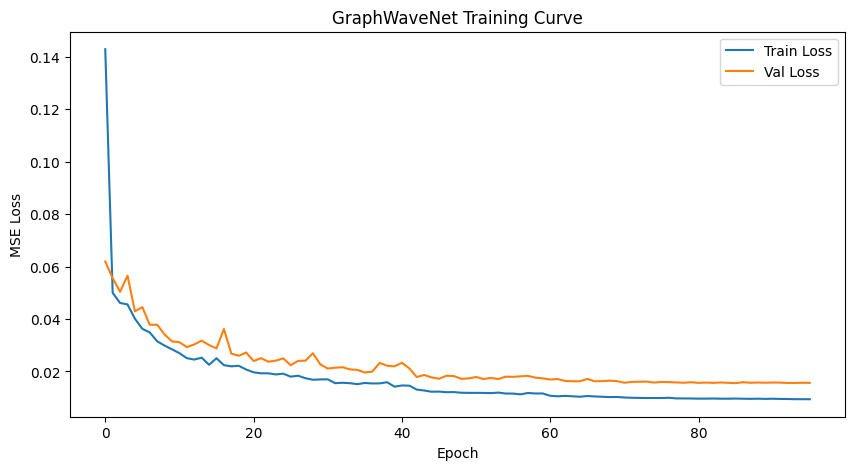

/tmp/ipykernel_3937683/1430645757.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_gwn.load_state_dict(torch.load("gwn_best.pth"))


Loaded best GraphWaveNet model.
Preds shape: torch.Size([32, 3, 16, 12, 2])
GT shape: torch.Size([32, 3, 16, 12, 2])


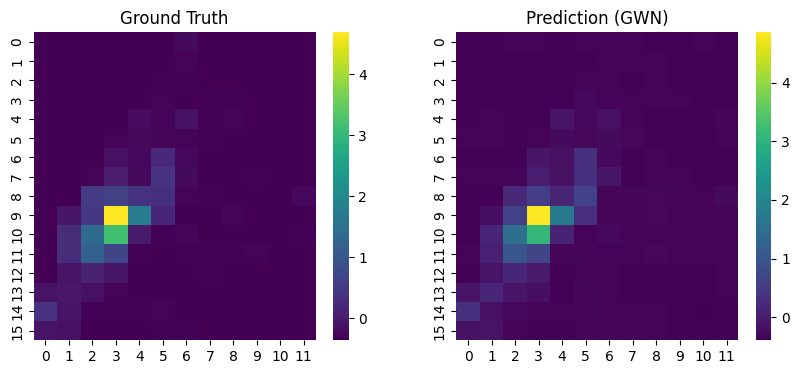

Validation MAE:  0.040905
Validation RMSE: 0.101025


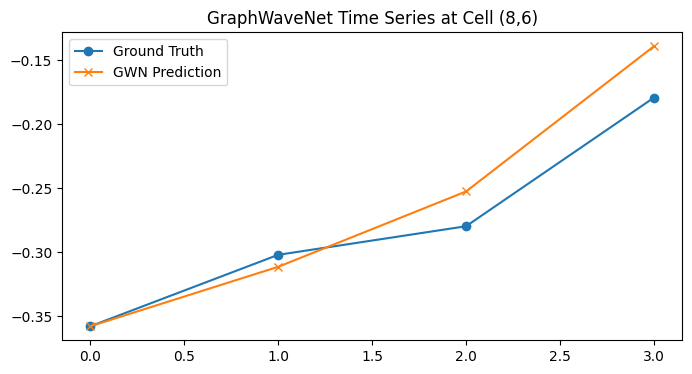

In [9]:
# ============================================
# Training Curve (GraphWaveNet)
# ============================================

plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("GraphWaveNet Training Curve")
plt.show()


# ============================================
# Load Best GraphWaveNet Model
# ============================================

best_gwn = GraphWaveNet(
    num_nodes=192, 
    in_dim=2,
    out_dim=2, 
    out_steps=3
).to(device)

best_gwn.load_state_dict(torch.load("gwn_best.pth"))
best_gwn.eval()

print("Loaded best GraphWaveNet model.")


# ============================================
# Predict on validation batch
# ============================================

X_batch, Y_batch = next(iter(val_loader))
Xb = X_batch.to(device)
Yb = Y_batch.to(device)

with torch.no_grad():
    pred_raw = best_gwn(to_gwn_input(Xb))   # (B, out_steps*out_dim, N)
    preds = from_gwn_output(pred_raw).to(device)  # (B,3,16,12,2)

print("Preds shape:", preds.shape)
print("GT shape:", Y_batch.shape)


# ============================================
# GT vs Prediction Heatmap
# ============================================

b = 0   # batch index
t = 0   # timestep index (0=next step)
ch = 0  # inflow

gt = Yb[b, t, :, :, ch].cpu().numpy()
pd = preds[b, t, :, :, ch].cpu().numpy()

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("Ground Truth")
sns.heatmap(gt, cmap="viridis")

plt.subplot(1,2,2)
plt.title("Prediction (GWN)")
sns.heatmap(pd, cmap="viridis")

plt.show()


# ============================================
# Compute MAE & RMSE
# ============================================

mae = torch.mean(torch.abs(preds - Yb)).item()
rmse = torch.sqrt(torch.mean((preds - Yb)**2)).item()

print(f"Validation MAE:  {mae:.6f}")
print(f"Validation RMSE: {rmse:.6f}")


# ============================================
# Time-series comparison at one grid cell
# Same as STGCN version
# ============================================

i, j = 8, 6   # select cell (same as STGCN)

input_last = Xb[b, -1, i, j, ch].cpu().numpy()
gt_series = Yb[b, :, i, j, ch].cpu().numpy()
pd_series = preds[b, :, i, j, ch].cpu().numpy()

series_gt = np.concatenate([[input_last], gt_series])
series_pd = np.concatenate([[input_last], pd_series])

plt.figure(figsize=(8,4))
plt.plot(series_gt, marker="o", label="Ground Truth")
plt.plot(series_pd, marker="x", label="GWN Prediction")
plt.title(f"GraphWaveNet Time Series at Cell ({i},{j})")
plt.legend()
plt.show()


GWN preds: torch.Size([32, 3, 16, 12, 2])
GT: torch.Size([32, 3, 16, 12, 2])


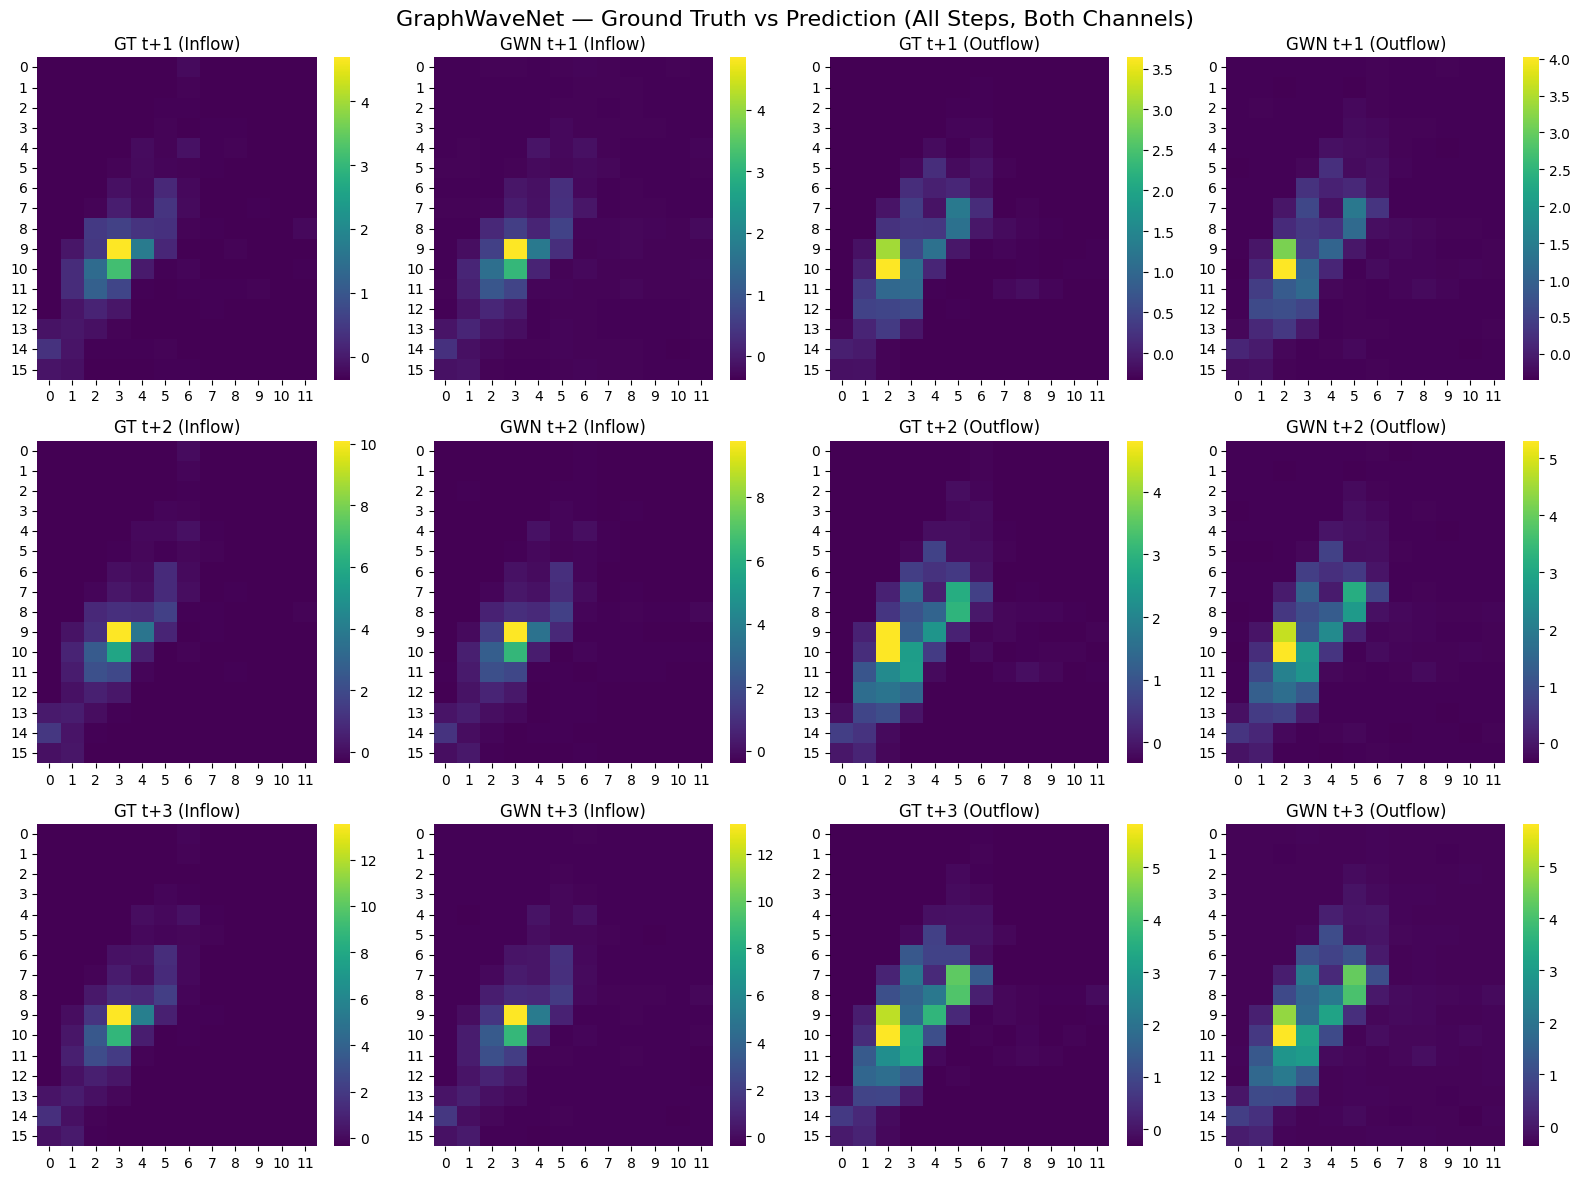

In [10]:
# ============================
# Select one validation batch
# ============================
X_batch, Y_batch = next(iter(val_loader))
Xb = X_batch.to(device)
Yb = Y_batch.to(device)

# ============================
# Run GWN on batch
# ============================
with torch.no_grad():
    pred_raw = best_gwn(to_gwn_input(Xb))
    preds_gwn = from_gwn_output(pred_raw)   # (B,3,16,12,2)

print("GWN preds:", preds_gwn.shape)
print("GT:", Yb.shape)

# ============================
# Visualization (3 steps × 2 channels)
# ============================

b = 0  # sample index
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle("GraphWaveNet — Ground Truth vs Prediction (All Steps, Both Channels)", fontsize=16)

steps = ["t+1", "t+2", "t+3"]
channels = ["Inflow", "Outflow"]

for t in range(3):              # t+1, t+2, t+3
    for ch in range(2):         # 0=inflow, 1=outflow

        gt  = Yb[b, t, :, :, ch].cpu().numpy()
        pred = preds_gwn[b, t, :, :, ch].cpu().numpy()

        ax_gt   = axes[t, ch*2]
        ax_pred = axes[t, ch*2 + 1]

        sns.heatmap(gt, ax=ax_gt, cmap="viridis")
        sns.heatmap(pred, ax=ax_pred, cmap="viridis")

        ax_gt.set_title(f"GT {steps[t]} ({channels[ch]})")
        ax_pred.set_title(f"GWN {steps[t]} ({channels[ch]})")

plt.tight_layout()
plt.show()
